# Dendrogramの座標計算


In [1]:
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt

# ダミーデータの準備 (5点)
X = np.array([
    [1.0, 1.0], [1.5, 1.5], [4.0, 4.0], [4.5, 4.5], [0.0, 5.0]
])
n_points = len(X)

# 連結行列 Z の生成 (ここではScipyを使用。このZを入力として使います)
# Z: [c1, c2, distance, count]
Z = linkage(X, method='single', metric='euclidean')

# Zの内容 (参考)
# print("連結行列 Z:\n", Z)

In [2]:
def compute_dendrogram_coords_scratch(Z, n_points):
    """
    連結行列 Zからデンドログラムの座標を計算します。

    Args:
        Z (numpy.ndarray): 連結行列 (n_points-1 x 4)。
        n_points (int): 元のデータ点数。

    Returns:
        tuple: (icoord, dcoord, leaf_order)
               icoord: X座標リスト (描画用)
               dcoord: Y座標リスト (描画用)
               leaf_order: 葉のインデックス順 (X軸の順序)
    """

    # --- 1. ノード情報の準備 ---
    # ノード総数 (葉 n_points + 内部ノード n_points-1)
    n_nodes = 2 * n_points - 1

    # ノード情報の初期化 (インデックス n_points-1 までが葉)
    # 葉ノード: x=None, y=0, size=1, left=None, right=None
    # 内部ノード: x=None, y=distance, size=count, left=c1, right=c2
    nodes = [{'x': None, 'y': 0.0, 'size': 1, 'left': None, 'right': None} for _ in range(n_points)]
    
    # 内部ノード情報をZから設定
    for i in range(n_points - 1):
        c1, c2, dist, count = Z[i]
        nodes.append({
            'x': None,
            'y': dist,
            'size': int(count),
            'left': int(c1),
            'right': int(c2)
        })

    # --- 2. X座標と葉の順序の再帰的計算 ---
    
    # ノードが持つ葉の順序リスト (インデックス) を返す
    def get_leaf_order(node_idx):
        node = nodes[node_idx]
        
        # ベースケース: 葉ノード
        if node_idx < n_points:
            return [node_idx] # 自身のインデックスを返す
        
        # 再帰ステップ: 内部ノード
        order_left = get_leaf_order(node['left'])
        order_right = get_leaf_order(node['right'])
        
        return order_left + order_right

    # X座標を決定する再帰関数
    def calculate_x_coord(node_idx, leaf_to_x):
        node = nodes[node_idx]
        
        # ベースケース: 葉ノード
        if node_idx < n_points:
            # 葉のX座標は、順序に基づいて 1, 3, 5, ... のように割り当てる
            x_coord = leaf_to_x[node_idx]
            node['x'] = x_coord
            return x_coord
        
        # 再帰ステップ: 内部ノード
        x_left = calculate_x_coord(node['left'], leaf_to_x)
        x_right = calculate_x_coord(node['right'], leaf_to_x)
        
        # 内部ノードのX座標は、子ノードのX座標の平均
        x_coord = (x_left + x_right) / 2.0
        node['x'] = x_coord
        return x_coord

    # まず葉の順序を決定 (最上位ノードからトラバース)
    root_node_idx = n_points - 1 + (n_points - 1) # 最後のZ行がルートノード
    leaf_order = get_leaf_order(root_node_idx)

    # 葉のX座標の割り当て (1, 3, 5, ...)
    leaf_to_x = {leaf_idx: 2 * i + 1 for i, leaf_idx in enumerate(leaf_order)}
    
    # X座標の計算をルートから実行
    calculate_x_coord(root_node_idx, leaf_to_x)


    # --- 3. 描画用線分 (icoord, dcoord) の生成 ---
    
    icoord = [] # X座標リスト [x1, x2, x3, x4]
    dcoord = [] # Y座標リスト [y1, y2, y3, y4]

    for i in range(n_points - 1):
        P = n_points + i # 親ノード P のインデックス
        C1 = nodes[P]['left']  # 左の子ノードのインデックス
        C2 = nodes[P]['right'] # 右の子ノードのインデックス

        # Y座標 (マージレベル)
        y_P = nodes[P]['y']
        y_C1 = nodes[C1]['y']
        y_C2 = nodes[C2]['y']

        # X座標
        x_P = nodes[P]['x']
        x_C1 = nodes[C1]['x']
        x_C2 = nodes[C2]['x']

        # 枝の線分の構成 (U字/Z字型)
        # 4つの点: (x_C1, y_C1) -> (x_C1, y_P) -> (x_C2, y_P) -> (x_C2, y_C2)
        # scipyのdendrogram出力形式に合わせるため、少し特殊な点の並びになります
        # 点1 (左の下端/マージ点): (x_C1, y_C1 または y_P)
        # 点2 (マージ点): (x_C1, y_P) または (x_P, y_P)
        # 点3 (マージ点): (x_C2, y_P) または (x_P, y_P)
        # 点4 (右の下端/マージ点): (x_C2, y_C2 または y_P)
        
        # ここでは、簡略化のため、線分を個別に作成します
        # 縦線: C1のX軸からy_C1->y_P
        # 横線: x_C1からx_C2、高さy_P
        # 縦線: C2のX軸からy_C2->y_P
        
        # scipyの出力形式に合わせて、4点の座標を格納
        # (x_C1, y_C1) -> (x_C1, y_P) -> (x_C2, y_P) -> (x_C2, y_C2)
        icoord.append([x_C1, x_C1, x_C2, x_C2])
        dcoord.append([y_C1, y_P, y_P, y_C2])

    return icoord, dcoord, leaf_order


--- スクラッチ計算結果 ---
葉の順序 (leaf_order): [4, 0, 1, 2, 3]


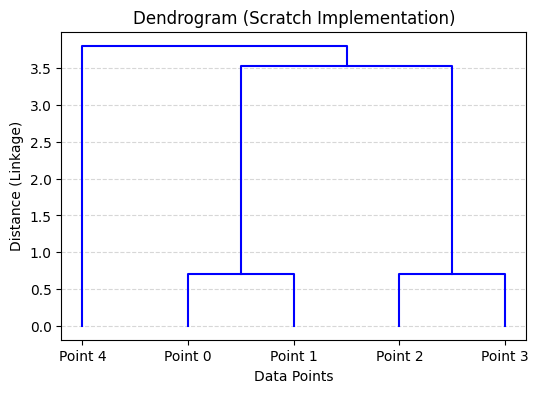

: 

In [ ]:
# 4. スクラッチ関数を実行
icoord_scratch, dcoord_scratch, leaf_order = compute_dendrogram_coords_scratch(Z, n_points)

print("\n--- スクラッチ計算結果 ---")
print("葉の順序 (leaf_order):", leaf_order)

# 5. 描画
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Dendrogram (Scratch Implementation)")

# 各枝を描画
for xs, ys in zip(icoord_scratch, dcoord_scratch):
    ax.plot(xs, ys, 'b-')

# X軸の目盛りとラベルを設定
# X座標は 1, 3, 5, ... となるため、目盛りは 1, 3, 5, ...
leaf_x_coords = [2 * i + 1 for i in range(n_points)]
ax.set_xticks(leaf_x_coords)
ax.set_xticklabels([f"Point {i}" for i in leaf_order])
ax.set_ylabel('Distance (Linkage)')
ax.set_xlabel('Data Points')
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

# --- 比較のため、scipy標準の描画も実行 (参考) ---
# plt.figure(figsize=(6, 4))
# plt.title("Dendrogram (Scipy Standard)")
# dendrogram(Z, labels=[f"Point {i}" for i in range(n_points)])
# plt.show()

# HDBSCAN用の座標計算

# 